In [23]:
import pandas as pd
import geopandas as gpd
import osmnx as ox

import sys
sys.path.append('../../') 
from src.graph.create_osmnx_graph import OSMnxGraph

from srai.plotting import plot_regions
from srai.regionalizers import geocode_to_region_gdf
from srai.regionalizers import H3Regionalizer
from srai.joiners import IntersectionJoiner

In [7]:
cities = ['seattle', 'new_york']

for city in cities:
    data_folder = f'../../data/downstream_tasks/airbnb/{city}'
    data = pd.read_csv(f'{data_folder}/airbnb_{city}.csv')
    data.dropna(subset='price', inplace=True)
    data.drop(columns=['id', 'host_id', 'host_name', 'neighbourhood_group','license'], inplace=True)
    data.to_csv(f'{data_folder}/airbnb_{city}_cleaned.csv')

In [62]:
def create_gdf_airbnb_price(data):
    gdf = gpd.GeoDataFrame(
                data.drop(["latitude", "longitude"], axis=1),
                geometry=gpd.points_from_xy(x=data["longitude"], y=data["latitude"]),
                crs="EPSG:4326",
            )
    gdf_price = gdf[['geometry', 'price']]
    gdf_price.reset_index(inplace=True)
    gdf_price.rename(columns={'index': 'feature_id'}, inplace=True)
    
    return gdf_price

In [63]:
def join_df(city_name, resolution, gdf_price):
    area = geocode_to_region_gdf(f"{city_name}, USA")
    regionalizer = H3Regionalizer(resolution=resolution)
    regions = regionalizer.transform(area)  

    joiner = IntersectionJoiner()
    joint_df = (
            joiner.transform(regions, gdf_price)

        )
    joint_df.reset_index(inplace=True)
    return joint_df, regions

In [64]:
def add_class_to_df(data, merged_df):
    
    q1 = data['price'].quantile(0.25)
    q2 = data['price'].quantile(0.5)
    q3 = data['price'].quantile(0.75)
    
    bins = [0, q1,  q2, q3, float("inf")]
    label_names = ['low', 'medium', 'high', 'very high']
    merged_df['price_class'] = pd.cut(merged_df['price'], bins=bins, labels=label_names, right=True)

    return merged_df

In [65]:
def airbnb_avg_prices_in_regions(city, resolution=9):
    
    data_folder = f'../../data/downstream_tasks/airbnb/{city}'
    data = pd.read_csv(f'{data_folder}/airbnb_{city}_cleaned.csv')
    
    gdf_price = create_gdf_airbnb_price(data)
    
    if city == "new_york":
        city_name = "New York City"
    if city == "seattle":
        city_name = "Seattle"
        
    joint_df, regions = join_df(city_name, resolution, gdf_price)
    df_price = pd.merge(joint_df, gdf_price, how='inner', on='feature_id')
    merged_df = pd.merge(regions, df_price, how='left', on='region_id')
    
    avg_price_df = merged_df.groupby(by='region_id')['price'].mean().reset_index()
    avg_price_df = add_class_to_df(data, avg_price_df)
    if 'no airbnb' not in avg_price_df['price_class'].cat.categories:
        avg_price_df['price_class'] = avg_price_df['price_class'].cat.add_categories('no airbnb')
    avg_price_df['price_class'].fillna('no airbnb', inplace=True)

    avg_price_df.to_csv(f'../../data/downstream_tasks/airbnb/{city}/{city}_airbnb_in_hexes_res_{resolution}.csv', index=False)

In [66]:
resolutions = [8, 9, 10]
cities = ['seattle', 'new_york']

for city in cities:
    for resolution in resolutions:
        airbnb_avg_prices_in_regions(city, resolution)

/var/folders/4k/8js3jm9n457cm4_v631zyrkw0000gn/T/ipykernel_73457/372639583.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_price.rename(columns={'index': 'feature_id'}, inplace=True)
/var/folders/4k/8js3jm9n457cm4_v631zyrkw0000gn/T/ipykernel_73457/372639583.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_price.rename(columns={'index': 'feature_id'}, inplace=True)
/var/folders/4k/8js3jm9n457cm4_v631zyrkw0000gn/T/ipykernel_73457/372639583.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

### Prices for each city and resolution

In [84]:
cities = ['seattle', 'new_york']
resolutions = [8, 9, 10]

for city in cities:
    for resolution in resolutions:
        print(f'{city}, resolution = {resolution}\n')
        
        file_path = f'../../data/downstream_tasks/airbnb/{city}/{city}_airbnb_in_hexes_res_{resolution}.csv'
        df = pd.read_csv(file_path, index_col='region_id')
        
        print(df.info())
        
        print('Price Statistics:')
        display(df['price'].describe().reset_index())
        
        print('Counts for each category in price_class column:')
        display(df['price_class'].value_counts().reset_index())
        
        print('Mean Price for each price_class:')
        display(df.groupby(by='price_class').mean().reset_index())
        
        print('--' * 20)


seattle, resolution = 8

<class 'pandas.core.frame.DataFrame'>
Index: 644 entries, 8828d54001fffff to 8828d5cdbdfffff
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        334 non-null    float64
 1   price_class  644 non-null    object 
dtypes: float64(1), object(1)
memory usage: 15.1+ KB
None
Price Statistics:


,index,price
0,count,334.000000
1,mean,168.236494
2,std,85.993031
3,min,42.333333
4,25%,125.547980
5,50%,149.947368
6,75%,179.758036
7,max,879.000000


Counts for each category in price_class column:


,price_class,count
0,no airbnb,310
1,high,169
2,very high,77
3,medium,66
4,low,22


Mean Price for each price_class:


,price_class,price
0,high,151.858860
1,low,80.311082
2,medium,113.495989
3,no airbnb,NaN
4,very high,276.224187


----------------------------------------
seattle, resolution = 9

<class 'pandas.core.frame.DataFrame'>
Index: 4203 entries, 8928d540003ffff to 8928d5cdbdbffff
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        1450 non-null   float64
 1   price_class  4203 non-null   object 
dtypes: float64(1), object(1)
memory usage: 98.5+ KB
None
Price Statistics:


,index,price
0,count,1450.000000
1,mean,165.198338
2,std,129.410194
3,min,27.000000
4,25%,105.750000
5,50%,140.000000
6,75%,187.000000
7,max,2315.750000


Counts for each category in price_class column:


,price_class,count
0,no airbnb,2753
1,high,468
2,very high,388
3,medium,345
4,low,249


Mean Price for each price_class:


,price_class,price
0,high,151.495474
1,low,75.240620
2,medium,111.325583
3,no airbnb,NaN
4,very high,287.359455


----------------------------------------
seattle, resolution = 10

<class 'pandas.core.frame.DataFrame'>
Index: 28545 entries, 8a28d5400007fff to 8a28d5cdbdb7fff
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        3503 non-null   float64
 1   price_class  28545 non-null  object 
dtypes: float64(1), object(1)
memory usage: 669.0+ KB
None
Price Statistics:


,index,price
0,count,3503.000000
1,mean,165.297828
2,std,165.687922
3,min,26.000000
4,25%,98.000000
5,50%,132.000000
6,75%,185.000000
7,max,4000.000000


Counts for each category in price_class column:


,price_class,count
0,no airbnb,25042
1,high,973
2,very high,892
3,low,823
4,medium,815


Mean Price for each price_class:


,price_class,price
0,high,151.920227
1,low,72.715073
2,medium,111.060672
3,no airbnb,NaN
4,very high,314.866544


----------------------------------------
new_york, resolution = 8

<class 'pandas.core.frame.DataFrame'>
Index: 1772 entries, 882a100001fffff to 882a10776dfffff
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        831 non-null    float64
 1   price_class  1772 non-null   object 
dtypes: float64(1), object(1)
memory usage: 41.5+ KB
None
Price Statistics:


,index,price
0,count,831.000000
1,mean,161.784800
2,std,166.551982
3,min,27.000000
4,25%,96.611336
5,50%,129.636364
6,75%,176.000000
7,max,3480.666667


Counts for each category in price_class column:


,price_class,count
0,no airbnb,941
1,medium,337
2,high,270
3,very high,115
4,low,109


Mean Price for each price_class:


,price_class,price
0,high,168.837152
1,low,65.970953
2,medium,106.619137
3,no airbnb,NaN
4,very high,397.701349


----------------------------------------
new_york, resolution = 9

<class 'pandas.core.frame.DataFrame'>
Index: 11849 entries, 892a1000003ffff to 892a10776dbffff
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        3266 non-null   float64
 1   price_class  11849 non-null  object 
dtypes: float64(1), object(1)
memory usage: 277.7+ KB
None
Price Statistics:


,index,price
0,count,3266.000000
1,mean,167.951715
2,std,253.243324
3,min,26.500000
4,25%,88.500000
5,50%,123.664474
6,75%,185.928571
7,max,9994.000000


Counts for each category in price_class column:


,price_class,count
0,no airbnb,8583
1,medium,1195
2,high,871
3,low,653
4,very high,547


Mean Price for each price_class:


,price_class,price
0,high,173.121299
1,low,61.340165
2,medium,106.579740
3,no airbnb,NaN
4,very high,421.067155


----------------------------------------
new_york, resolution = 10

<class 'pandas.core.frame.DataFrame'>
Index: 81463 entries, 8a2a10000007fff to 8a2a10776db7fff
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        9363 non-null   float64
 1   price_class  81463 non-null  object 
dtypes: float64(1), object(1)
memory usage: 1.9+ MB
None
Price Statistics:


,index,price
0,count,9363.000000
1,mean,186.588431
2,std,584.441302
3,min,16.500000
4,25%,83.666667
5,50%,129.000000
6,75%,204.000000
7,max,50128.000000


Counts for each category in price_class column:


,price_class,count
0,no airbnb,72100
1,medium,2753
2,high,2495
3,low,2220
4,very high,1895


Mean Price for each price_class:


,price_class,price
0,high,176.127881
1,low,58.328683
2,medium,106.688189
3,no airbnb,NaN
4,very high,466.694541


----------------------------------------


### example visualization

In [24]:
city = 'seattle'
data_folder = f'../../data/downstream_tasks/airbnb/{city}'
data = pd.read_csv(f'{data_folder}/airbnb_{city}_cleaned.csv')
gdf_price = create_gdf_airbnb_price(data)
    
area = geocode_to_region_gdf("Seattle, USA") 
regionalizer = H3Regionalizer(resolution=8)
regions = regionalizer.transform(area)

folium_map = plot_regions(regions, colormap=["cornflowerblue"])
gdf_price.explore(
    m=folium_map,
    style_kwds=dict(color="darkblue", opacity=0.5, fillColor="darkblue", fillOpacity=0.5),
    marker_kwds=dict(radius=2),
)

/var/folders/4k/8js3jm9n457cm4_v631zyrkw0000gn/T/ipykernel_73457/372639583.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_price.rename(columns={'index': 'feature_id'}, inplace=True)


### osmnx

In [26]:
area = "Seattle, USA"

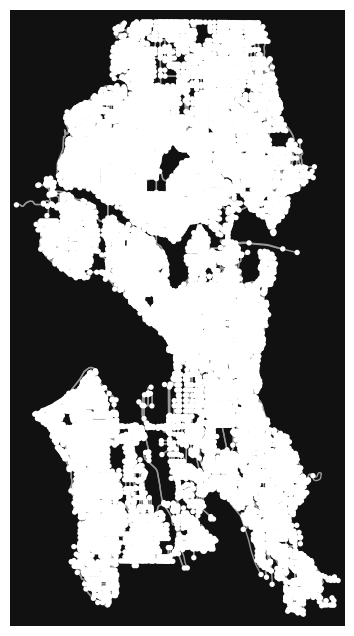

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [27]:
G = ox.graph.graph_from_place(area, network_type="drive")
ox.plot_graph(G)

In [28]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
display(gdf_nodes)
display(gdf_edges)

,y,x,ref,highway,street_count,geometry
osmid,,,,,,
29445663,47.638537,-122.322633,168B,motorway_junction,3,POINT (-122.32263 47.63854)
29447670,47.643310,-122.308912,NaN,motorway_junction,3,POINT (-122.30891 47.64331)
29449421,47.643335,-122.309159,NaN,NaN,3,POINT (-122.30916 47.64334)
29449538,47.642670,-122.320294,NaN,motorway_junction,3,POINT (-122.32029 47.64267)
29449863,47.644000,-122.303978,NaN,traffic_signals,4,POINT (-122.30398 47.64400)
...,...,...,...,...,...,...
11813177979,47.713076,-122.326730,NaN,NaN,1,POINT (-122.32673 47.71308)
11833209193,47.560026,-122.302395,NaN,NaN,3,POINT (-122.30240 47.56003)
11873130099,47.576974,-122.310085,NaN,crossing,4,POINT (-122.31008 47.57697)


osmid  \
u           v           key                                                      
29445663    335444348   0                                              4634309   
            29485641    0                                            608025479   
29447670    3391701882  0              [40416106, 4635028, 607798222, 4634847]   
            7010447296  0    [40416108, 981053037, 981053038, 424807772, 14...   
29449421    9567450119  0                   [1052610031, 446010581, 143178399]   
...                                                                        ...   
11873130099 53171882    0                               [532188897, 428006483]   
11888744558 9092662577  0                                            158719580   
            9092662857  0                                            158719580   
            11888744559 0                                           1280830643   
11888744559 11888744558 0                                           1280830643   

                             oneway      lanes     ref  \
u           v           key                              
29445663    335444348   0      True          2  WA 520   
            29485641    0      True          3     I 5   
29447670    3391701882  0      True  [3, 2, 1]     NaN   
            7010447296  0      True          2  WA 520   
29449421    9567450119  0      True          2  WA 520   
...                             ...        ...     ...   
11873130099 53171882    0     False          3     NaN   
11888744558 9092662577  0     False          2     NaN   
            9092662857  0     False          2     NaN   
            11888744559 0     False        NaN     NaN   
11888744559 11888744558 0     False        NaN     NaN   

                                               highway          maxspeed  \
u           v           key                                                
29445663    335444348   0                motorway_link            60 mph   
            29485641    0                     motorway            60 mph   
29447670    3391701882  0                motorway_link               NaN   
            7010447296  0                     motorway  [40 mph, 60 mph]   
29449421    9567450119  0    [motorway_link, motorway]  [50 mph, 60 mph]   
...                                                ...               ...   
11873130099 53171882    0                    secondary            25 mph   
11888744558 9092662577  0                  residential            20 mph   
            9092662857  0                  residential            20 mph   
            11888744559 0                  residential               NaN   
11888744559 11888744558 0                  residential               NaN   

                            reversed   length  \
u           v           key                     
29445663    335444348   0      False  636.024   
            29485641    0      False  688.835   
29447670    3391701882  0      False  389.716   
            7010447296  0      False  477.094   
29449421    9567450119  0      False  715.929   
...                              ...      ...   
11873130099 53171882    0       True  220.887   
11888744558 9092662577  0      False   47.579   
            9092662857  0       True  145.539   
            11888744559 0      False   82.351   
11888744559 11888744558 0       True   82.351   

                                                                      geometry  \
u           v           key                                                      
29445663    335444348   0    LINESTRING (-122.32263 47.63854, -122.32251 47...   
            29485641    0    LINESTRING (-122.32263 47.63854, -122.32257 47...   
29447670    3391701882  0    LINESTRING (-122.30891 47.64331, -122.30805 47...   
            7010447296  0    LINESTRING (-122.30891 47.64331, -122.30663 47...   
29449421    9567450119  0    LINESTRING (-122.30916 47.64334, -122.30949 47...   
...                                               